Connected to Athena successfully!
Fetching max CO2 emissions data...


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_23329/295209145.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  max_co2_df = pd.read_sql(max_co2_query, conn)


Received data for 5 vehicles


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_23329/295209145.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='vehicle_id', y='max_co2', data=max_co2_df, palette='hls')


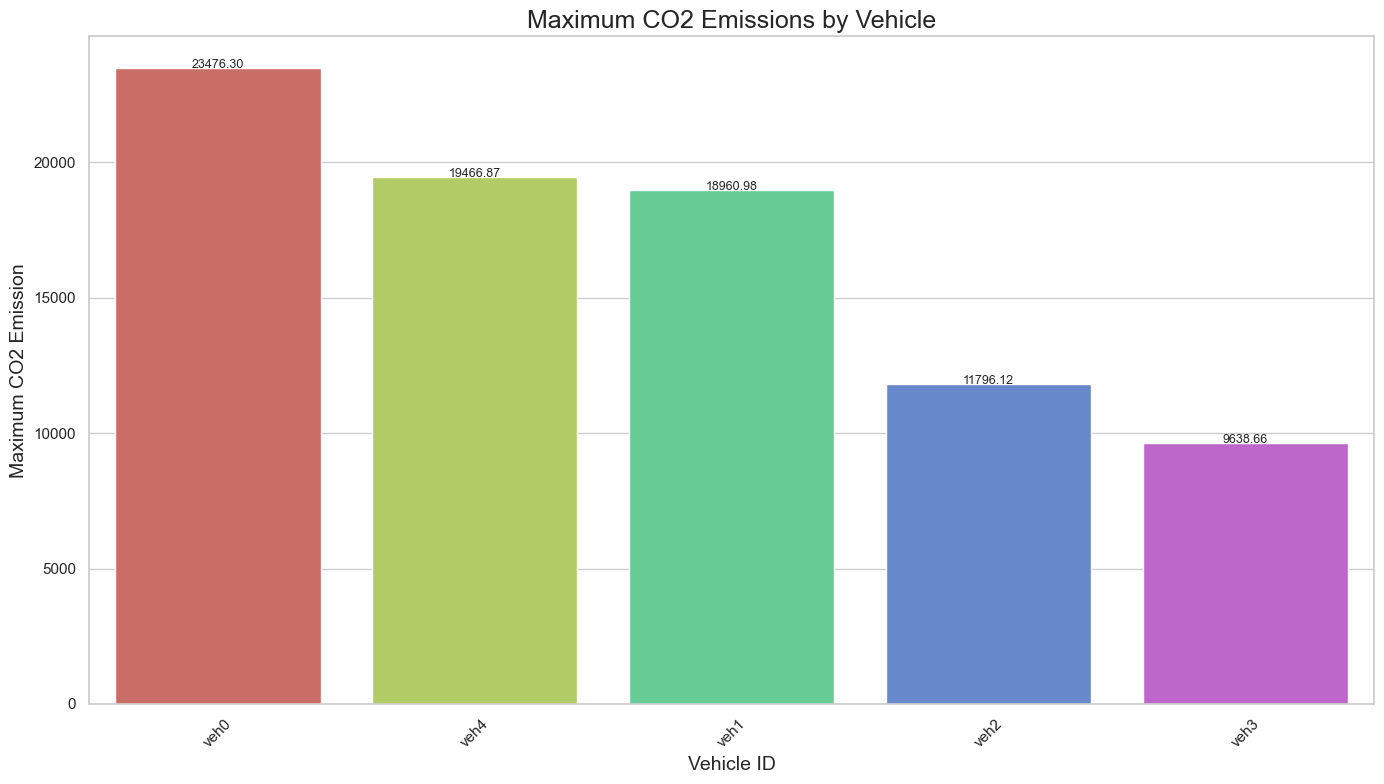


Fetching vehicle location data...


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_23329/295209145.py:95: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  location_df = pd.read_sql(trajectory_query, conn)


Received location data with 1390 data points
Color coding location map for 5 devices
Plotting location data for 5 vehicles


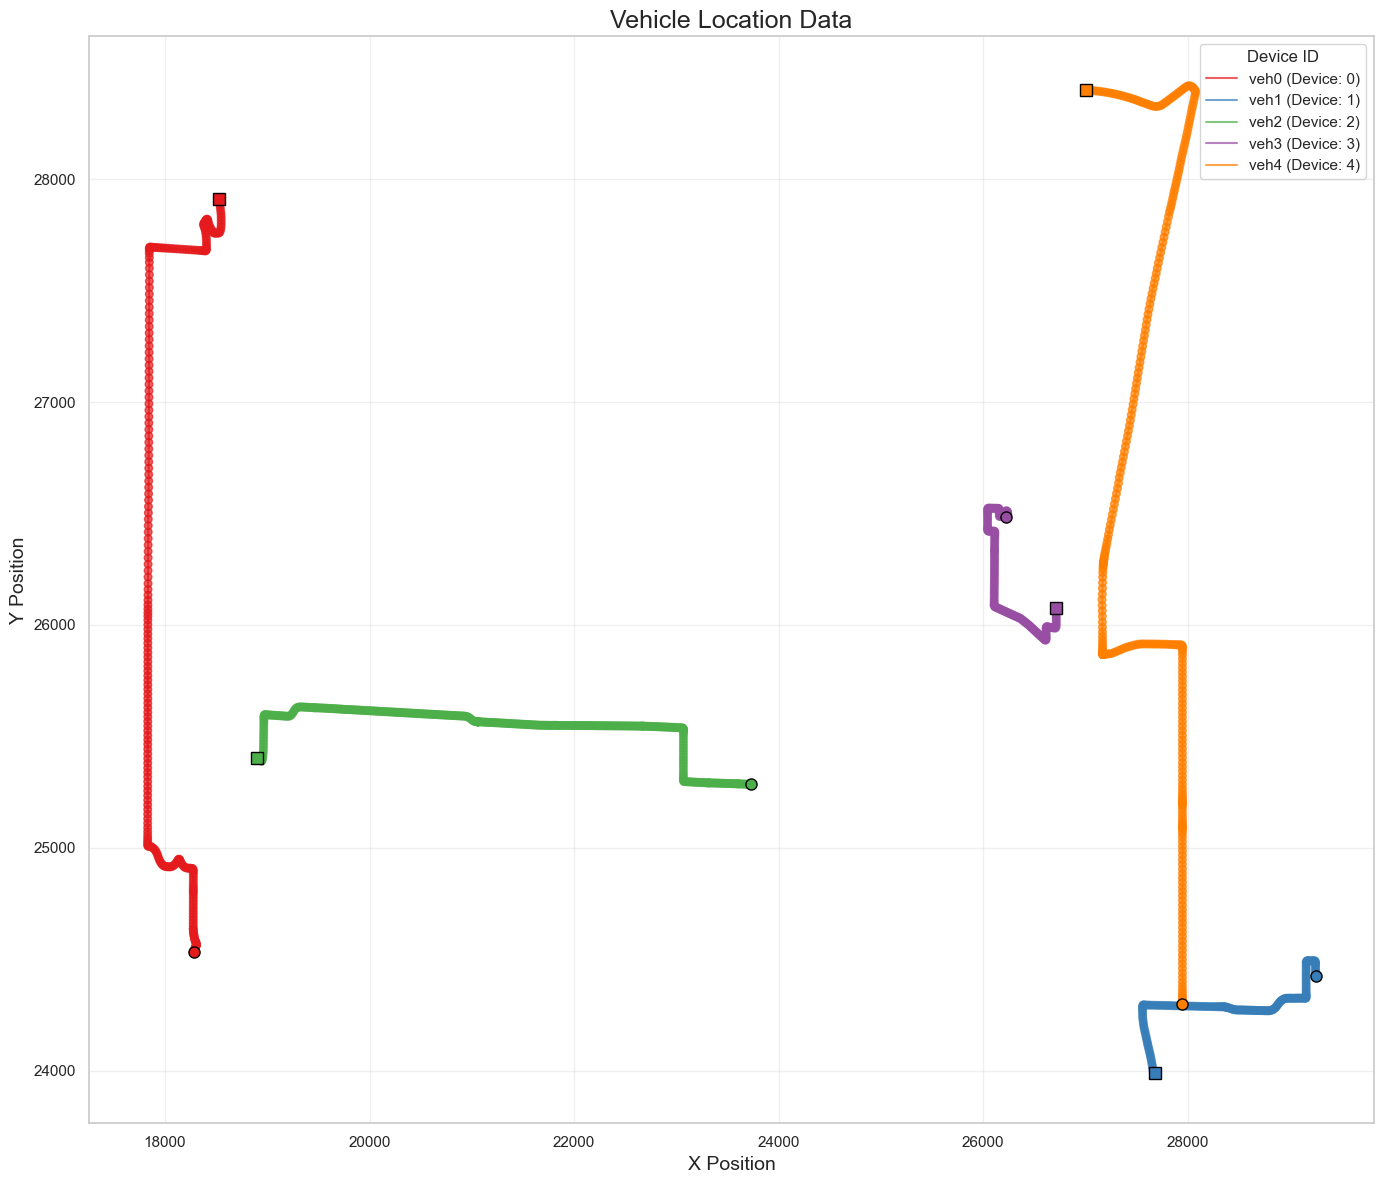


Fetching speed vs emissions data...


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_23329/295209145.py:191: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  speed_emissions_df = pd.read_sql(speed_emissions_query, conn)


Received speed vs emissions data with 743 data points


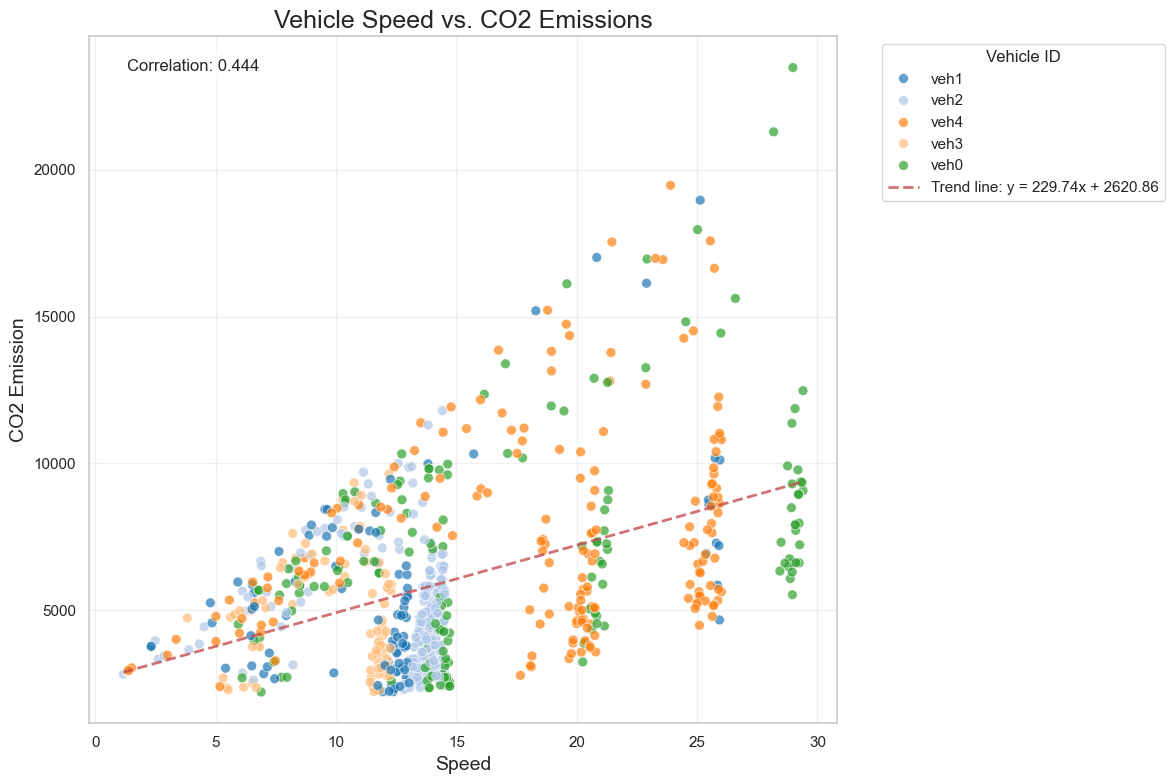


Fetching emission distribution by device data...


/var/folders/9v/4smhr8lx3ws0xdwsw3xjy5zw0000gn/T/ipykernel_23329/295209145.py:266: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  emission_dist_df = pd.read_sql(emission_dist_query, conn)


Received emission distribution data with 737 data points


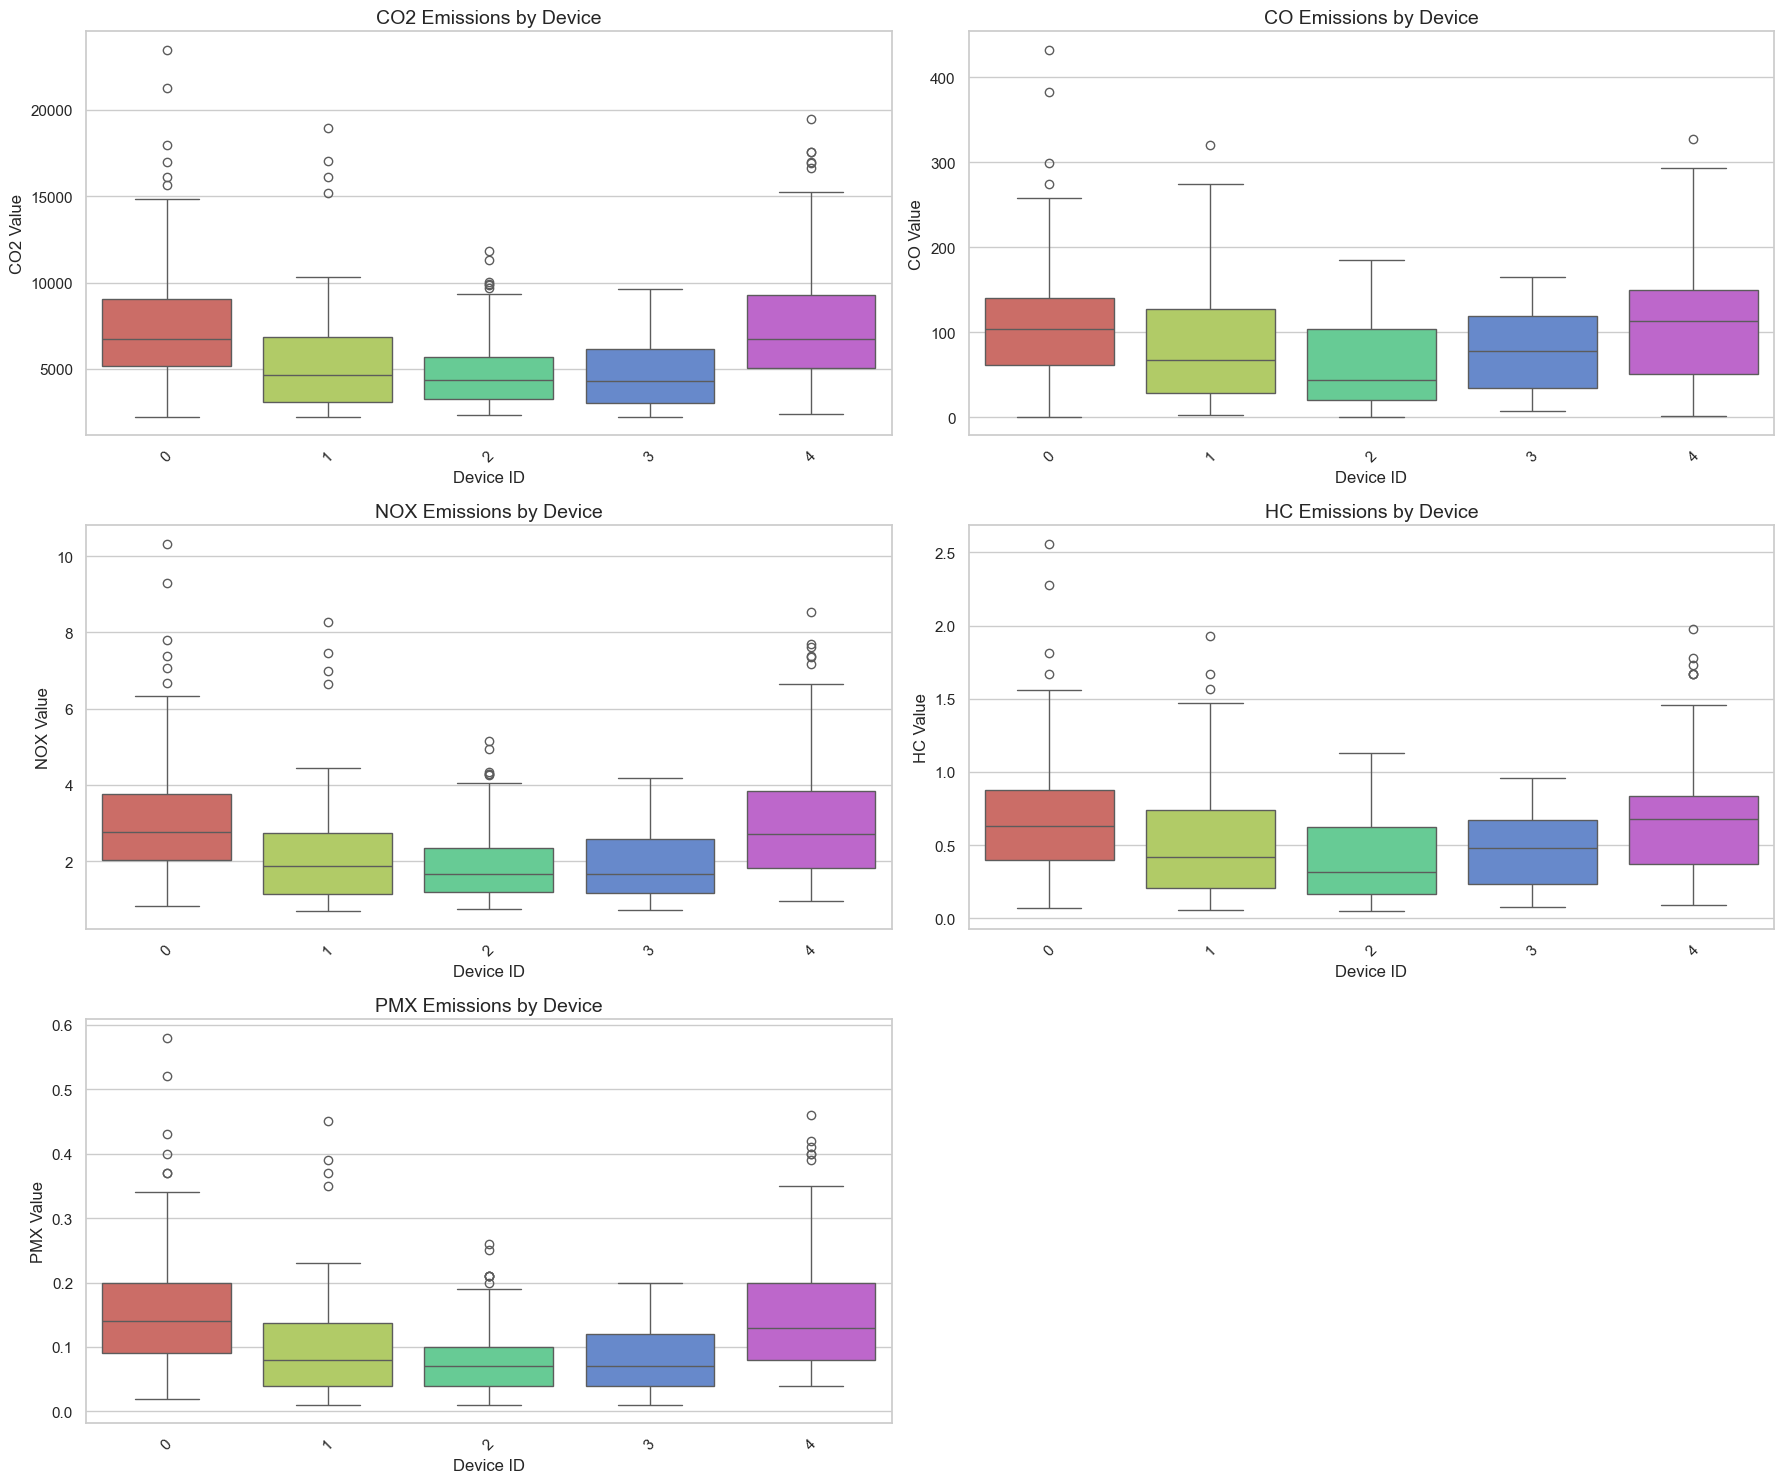


Summary Statistics:

Max CO2 Emissions by Vehicle:
            max_co2
count      5.000000
mean   16667.786000
std     5757.412934
min     9638.660000
25%    11796.120000
50%    18960.980000
75%    19466.870000
max    23476.300000

Speed vs. Emissions Correlation:
Correlation coefficient: 0.4439

Analysis complete. All visualizations have been generated.


In [21]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyathena import connect

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Establish connection to Athena
conn = connect(s3_staging_dir='s3://emissions-athena-results/',
               region_name='us-east-2')

print("Connected to Athena successfully!")

# ---------------------------------------------------
# VISUALIZATION 1: MAX CO2 EMISSIONS CHART
# ---------------------------------------------------
print("Fetching max CO2 emissions data...")

# Query to get the maximum CO2 emission for each vehicle
max_co2_query = """
SELECT 
    vehicle_id, 
    MAX(vehicle_co2) as max_co2
FROM 
    emissions_database.emissions_emissions_data_2
WHERE vehicle_id IS NOT NULL
GROUP BY 
    vehicle_id
ORDER BY 
    max_co2 DESC
"""

# Execute query and load into DataFrame
max_co2_df = pd.read_sql(max_co2_query, conn)
print(f"Received data for {len(max_co2_df)} vehicles")

# Create the max CO2 emissions chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='vehicle_id', y='max_co2', data=max_co2_df, palette='hls')
plt.title('Maximum CO2 Emissions by Vehicle', fontsize=18)
plt.xlabel('Vehicle ID', fontsize=14)
plt.ylabel('Maximum CO2 Emission', fontsize=14)
plt.xticks(rotation=45)

# Add value labels on top of the bars
for i, v in enumerate(max_co2_df['max_co2']):
    ax.text(i, v + 0.5, f'{v:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('max_co2_emissions.png', dpi=300)
plt.show()

# ---------------------------------------------------
# VISUALIZATION 2: VEHICLE TRAJECTORY (X/Y PLOT)
# ---------------------------------------------------
print("\nFetching vehicle location data...")

# Query to get trajectory data for multiple vehicles
trajectory_query = """
WITH vehicle_samples AS (
    SELECT 
        vehicle_id,
        device_id,
        COUNT(*) as data_points
    FROM 
        emissions_database.emissions_emissions_data_2
    WHERE 
        vehicle_id IS NOT NULL
        AND device_id IS NOT NULL
    GROUP BY 
        vehicle_id, device_id
    HAVING 
        COUNT(*) > 10
    ORDER BY data_points DESC
)
SELECT 
    e.vehicle_id,
    e.device_id,
    e.vehicle_x, 
    e.vehicle_y,
    e.timestep_time
FROM 
    emissions_database.emissions_emissions_data_2 e
JOIN 
    vehicle_samples v ON e.vehicle_id = v.vehicle_id AND e.device_id = v.device_id
ORDER BY 
    e.device_id, e.vehicle_id, e.timestep_time
"""

# Execute query and load into DataFrame
location_df = pd.read_sql(trajectory_query, conn)
print(f"Received location data with {len(location_df)} data points")

# Plot vehicle trajectories
plt.figure(figsize=(14, 12))

# Get unique device IDs for color coding
devices = location_df['device_id'].unique()
print(f"Color coding location map for {len(devices)} devices")

device_colors = [
    '#e41a1c',  # Red
    '#377eb8',  # Blue
    '#4daf4a',  # Green
    '#984ea3',  # Purple
    '#ff7f00',  # Orange
]

device_color_map = dict(zip(devices, [device_colors[i] for i in range(len(devices))]))

# Get unique vehicles
vehicles = location_df['vehicle_id'].unique()
print(f"Plotting location data for {len(vehicles)} vehicles")

# Plot each vehicle's trajectory, colored by device
for i, vehicle in enumerate(vehicles):
    vehicle_data = location_df[location_df['vehicle_id'] == vehicle].sort_values('timestep_time')
    
    if len(vehicle_data) == 0:
        continue
        
    device = vehicle_data['device_id'].iloc[0]
    color = device_color_map[device]
    
    # Plot the vehicle trajectory
    plt.plot(vehicle_data['vehicle_x'],
             vehicle_data['vehicle_y'], 
             '-',
             color=color,
             alpha=0.7,
             linewidth=1.5,
             label=f"{vehicle} (Device: {device})" if i == 0 or device not in [location_df.iloc[j]['device_id'] for j in range(i)] else "")
    
    # Mark the start and end points
    plt.plot(vehicle_data['vehicle_x'].iloc[0], 
             vehicle_data['vehicle_y'].iloc[0], 
             'o', 
             color=color, 
             markersize=8,
             markeredgecolor='black')
    
    plt.plot(vehicle_data['vehicle_x'].iloc[-1], 
             vehicle_data['vehicle_y'].iloc[-1], 
             's', 
             color=color, 
             markersize=8,
             markeredgecolor='black')

# Create a scatter plot with color by device
for device in devices:
    device_data = location_df[location_df['device_id'] == device]
    plt.scatter(device_data['vehicle_x'], 
                device_data['vehicle_y'], 
                c=[device_color_map[device]] * len(device_data),
                s=30, 
                alpha=0.7)

plt.title('Vehicle Location Data', fontsize=18)
plt.xlabel('X Position', fontsize=14)
plt.ylabel('Y Position', fontsize=14)
plt.legend(title='Device ID', title_fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('vehicle_location_data.png', dpi=300)
plt.show()

# ---------------------------------------------------
# VISUALIZATION 3: SPEED VS EMISSIONS CHART
# ---------------------------------------------------
print("\nFetching speed vs emissions data...")

# Query to get speed and emissions data
speed_emissions_query = """
SELECT 
    vehicle_id,
    vehicle_speed, 
    vehicle_co2
FROM 
    emissions_database.emissions_emissions_data_2
WHERE 
    vehicle_speed > 0
    AND vehicle_co2 > 0
    AND vehicle_id IS NOT NULL
"""

# Execute query and load into DataFrame
speed_emissions_df = pd.read_sql(speed_emissions_query, conn)
print(f"Received speed vs emissions data with {len(speed_emissions_df)} data points")

# Plot speed vs emissions with regression line
plt.figure(figsize=(12, 8))

# Create scatter plot
sns.scatterplot(
    x='vehicle_speed',
    y='vehicle_co2',
    hue='vehicle_id',
    data=speed_emissions_df,
    alpha=0.7,
    palette='tab20',
    s=50
)

# Calculate and add regression line
x = speed_emissions_df['vehicle_speed']
y = speed_emissions_df['vehicle_co2']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Add regression line to plot
x_range = np.linspace(x.min(), x.max(), 100)
plt.plot(x_range, p(x_range), "r--", linewidth=2, alpha=0.8, label=f'Trend line: y = {z[0]:.2f}x + {z[1]:.2f}')

# Calculate correlation
correlation = speed_emissions_df['vehicle_speed'].corr(speed_emissions_df['vehicle_co2'])

# Add annotation with correlation coefficient
plt.annotate(f'Correlation: {correlation:.3f}',
             xy=(0.05, 0.95),
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.title('Vehicle Speed vs. CO2 Emissions', fontsize=18)
plt.xlabel('Speed', fontsize=14)
plt.ylabel('CO2 Emission', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('speed_vs_emissions.png', dpi=300)
plt.show()

# ---------------------------------------------------
# VISUALIZATION 4: EMISSIONS DISTRIBUTION
# ---------------------------------------------------
print("\nFetching emission distribution by device data...")

# Query to get emission distribution by device
emission_dist_query = """
SELECT 
    device_id,
    vehicle_co2,
    vehicle_co,
    vehicle_nox,
    vehicle_hc,
    vehicle_pmx
FROM 
    emissions_database.emissions_emissions_data_2
WHERE 
    vehicle_id IS NOT NULL
    AND device_id IS NOT NULL
    AND vehicle_co2 > 0
    AND vehicle_co > 0
    AND vehicle_nox > 0
    AND vehicle_hc > 0
    AND vehicle_pmx > 0
ORDER BY 
    device_id, vehicle_co2
"""

# Execute query and load into DataFrame
emission_dist_df = pd.read_sql(emission_dist_query, conn)
print(f"Received emission distribution data with {len(emission_dist_df)} data points")

# Select a subset of devices for clearer visualization
devices = emission_dist_df['device_id'].value_counts().head(8).index.tolist()
filtered_df = emission_dist_df[emission_dist_df['device_id'].isin(devices)]

emission_types = ['vehicle_co2', 'vehicle_co', 'vehicle_nox', 'vehicle_hc', 'vehicle_pmx']

# Create boxplots for each emission type by device
plt.figure(figsize=(18, 15))

for i, emission_type in enumerate(emission_types):
    plt.subplot(3, 2, i + 1)

    # Extract the raw name for display
    display_name = emission_type.replace('vehicle_', '')

    # Create boxplot with the device_id assigned to both x and hue
    # This fixes the deprecation warning
    sns.boxplot(x='device_id', y=emission_type, hue='device_id', data=filtered_df, palette='hls', legend=False)
    
    plt.title(f'{display_name.upper()} Emissions by Device', fontsize=14)
    plt.xlabel('Device ID', fontsize=12)
    plt.ylabel(f'{display_name.upper()} Value', fontsize=12)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('emission_boxplots_by_device.png', dpi=300)
plt.show()

# ---------------------------------------------------
# SUMMARY STATS
# ---------------------------------------------------
print("\nSummary Statistics:")
print("\nMax CO2 Emissions by Vehicle:")
print(max_co2_df.describe())

print("\nSpeed vs. Emissions Correlation:")
print(f"Correlation coefficient: {correlation:.4f}")

# Close the connection
conn.close()
print("\nAnalysis complete. All visualizations have been generated.")